## Setup

In [ ]:
! pip install neuralogic
from neuralogic.core import Template, R, V
from neuralogic.dataset import Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 38.4 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/neuralogic/core/builder/builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
template = Template()

# GNN-like graph propagation
template +=  R.layer_1(V.X) <= (R.bond(V.X, V.Y, V.B))

### Dataset definition

In [ ]:
train_dataset = Dataset()
train_dataset.add_example(
    [
        R.o(1), R.h(2), R.h(3), # water
        R.bond(1, 2, 10), R.bond(1, 3, 11),
        R.b_1(10), R.b_1(11)
    ],
)
train_dataset.add_example(
    [
        R.o(1), R.h(2), R.h(3), R.h(4), R.h(5), R.c(6), # methanol
        R.bond(1, 2, 10), R.bond(6, 3, 11), R.bond(6, 4, 12), R.bond(6, 5, 13), R.bond(1, 6, 14),
        R.b_1(10), R.b_1(11), R.b_1(12), R.b_1(13), R.b_1(14)
    ],
)

## Bonding rules

In [ ]:
template += R.bond_message(V.X, V.Y, V.B) <= (R.atom_embed(V.X)[3, 3], R.atom_embed(V.Y)[3, 3], R.bond_embed(V.B)[3,3])

template += R.single_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_1(V.B), R.bond_message(V.X, V.Y, V.B))
template += R.single_bonded(V.X, V.Y, V.B) <= (R.bond(V.X, V.Y, V.B), R.b_1(V.B), R.bond_message(V.X, V.Y, V.B))

template += R.double_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_2(V.B), R.bond_message(V.X, V.Y, V.B))
template += R.double_bonded(V.X, V.Y, V.B) <= (R.bond(V.X, V.Y, V.B), R.b_2(V.B), R.bond_message(V.X, V.Y, V.B))

template += R.triple_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_3(V.B), R.bond_message(V.X, V.Y, V.B))
template += R.triple_bonded(V.X, V.Y, V.B) <= (R.bond(V.Y, V.X, V.B), R.b_3(V.B), R.bond_message(V.X, V.Y, V.B))

template += R.aromatic_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_7(V.B), R.bond_message(V.X, V.Y, V.B)) # maybe also 4, 5 - contained on furan ring both on same oxygen
template += R.aromatic_bonded(V.X, V.Y, V.B) <= (R.bond(V.X, V.Y, V.B), R.b_7(V.B), R.bond_message(V.X, V.Y, V.B))

In [ ]:
# define contains(Molecule, Atom)

## Saturation

In [ ]:
from neuralogic.core import Aggregation

template += R.saturated(V.X) <= (R.c(V.X),
                                 R.single_bonded(V.X, V.Y1),
                                 R.single_bonded(V.X, V.Y2),
                                 R.single_bonded(V.X, V.Y3),
                                 R.single_bonded(V.X, V.Y4),
                                 R.special.alldiff(...))
template += (R.saturated <= (R.saturated(V.X))) | [Aggregation.MIN]

## Predicition

layer_1(X) :- bond(X, Y, B).
single_bonded(X, Y) :- bond(X, Y, B), b_1(B).
single_bonded(X, Y) :- bond(Y, X, B), b_1(B).
saturated(X) :- c(X), single_bonded(X, Y1), single_bonded(X, Y2), single_bonded(X, Y3), single_bonded(X, Y4), @alldiff(Y1, X, Y2, Y4, Y3).
saturated :- saturated(X). [aggregation=min]
{1} predict :- layer_1(X).
{1} predict :- saturated.


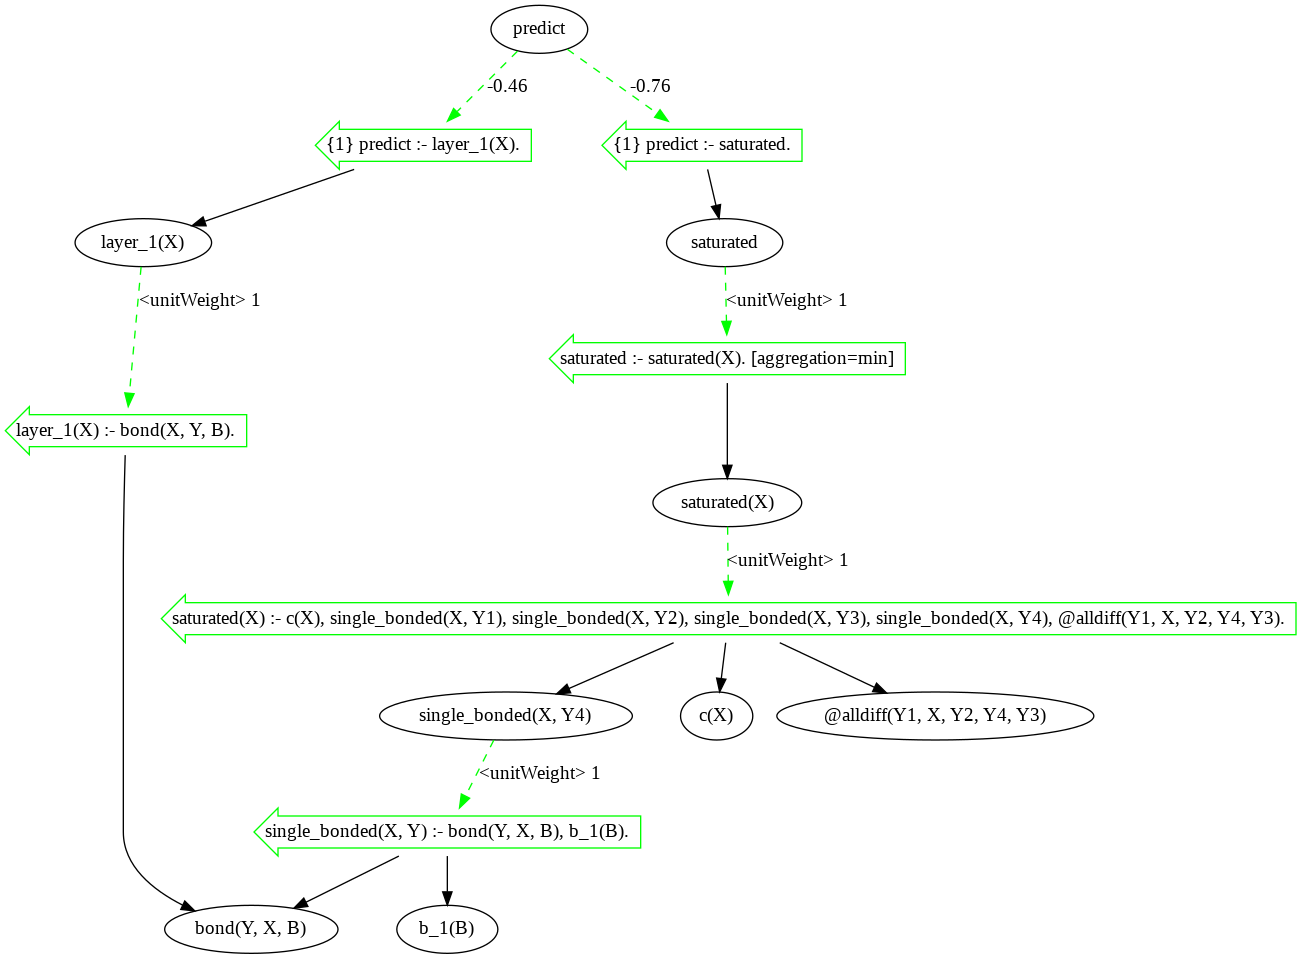

In [ ]:
from neuralogic.core.constructs.function.reshape import Transformation
template += R.predict[1,] <= R.layer_1(V.X) 
template += R.predict[1,] <= R.saturated

template += R.predict | [Transformation.SIGMOID]

train_dataset.add_queries([
    R.predict[0],
    R.predict[1],
])
print(template)
template.draw()

## Training

In [ ]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE, CrossEntropy
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam

settings = Settings(optimizer=Adam(lr=0.1), epochs=100, error_function=CrossEntropy())#, chain_pruning=True, iso_value_compression=True, prune_only_identities=True)
evaluator = get_evaluator(template, settings)

built_dataset = evaluator.build_dataset(train_dataset)

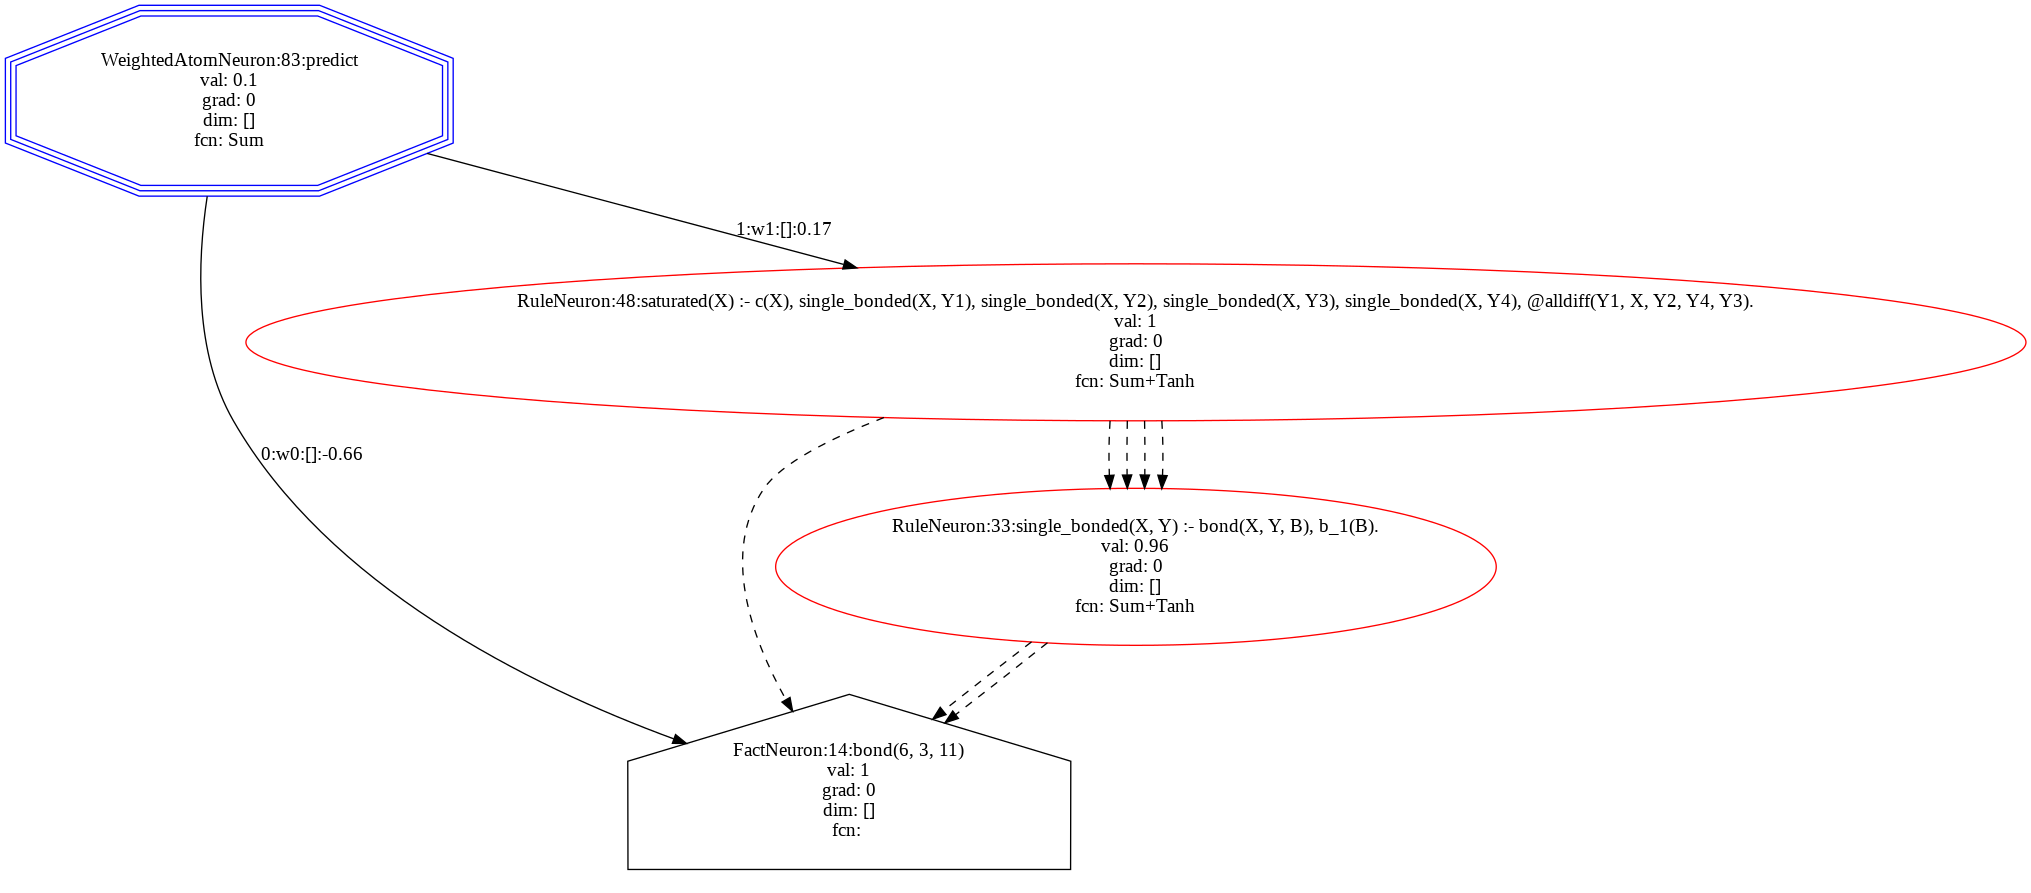

In [ ]:
built_dataset[1].draw()

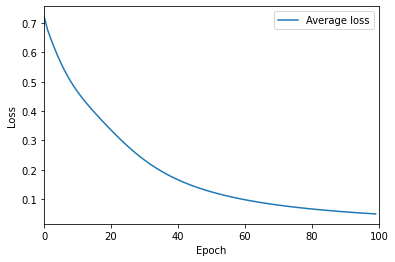

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

average_losses = []

for current_total_loss, number_of_samples in evaluator.train(built_dataset):
    clear_output(wait=True)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.xlim(0, settings.epochs)

    average_losses.append(current_total_loss / number_of_samples)
    
    plt.plot(average_losses, label="Average loss")

    plt.legend()
    plt.pause(0.001)
    plt.show()

In [ ]:
for sample, y_hat in zip(built_dataset.samples, evaluator.test(built_dataset)):
    print(f"Target: {sample.java_sample.target}, Predicted: {round(y_hat)} ({y_hat})")

Target: 0, Predicted: -3 (-2.7153803007733033)
Target: 1, Predicted: 3 (3.3657865113333023)
